In [200]:
import warnings
warnings.filterwarnings('ignore')

In [201]:
import sys

In [202]:
import numpy as np
import pandas as pd
import scipy
from scipy.optimize import minimize
import plotly.express as px
import plotly.graph_objects as go
import datetime
import matplotlib.pyplot as plt

from sklearn import linear_model as lm
from sklearn.feature_selection import r_regression
from sklearn.metrics import r2_score

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg

In [203]:
approval = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vS-FKWVTTFtJT6u56e0bqdfoMcXvDO1DUChsJ3jQAMB2lZk2SMqVfmg7dGjclTYkYWz-Pm5lfcLPjp4/pub?output=csv')
# approval = approval.reset_index()
# approval = approval.rename({'index':'poll_id'}, axis=1)
approval

,president,subgroup,pollster,sponsors,startdate,enddate,samplesize,population,weight,influence,tracking,approve,disapprove,net,adjusted_approve,adjusted_disapprove,adjusted_net,url,createddate,timestamp
0,Donald Trump (2nd term),Economy,Verasight,Strength in Numbers,10/24/2025,10/29/2025,1567.0,A,1.004010,1.00401,NaN,40.0,54.0,-14.0,40.05299,54.635620,-14.582630,https://www.gelliottmorris.com/p/new-poll-vote...,10/29/2025,14:00:58 31 Oct 2025
1,Donald Trump (2nd term),Immigration,Verasight,Strength in Numbers,10/24/2025,10/29/2025,1567.0,A,1.004010,1.00401,NaN,46.0,49.0,-3.0,46.03001,48.794720,-2.764709,https://www.gelliottmorris.com/p/new-poll-vote...,10/29/2025,14:01:01 31 Oct 2025
2,Donald Trump (2nd term),Cost,Verasight,Strength in Numbers,10/24/2025,10/29/2025,1567.0,A,1.004010,1.00401,NaN,35.0,61.0,-26.0,35.84896,60.378520,-24.529560,https://www.gelliottmorris.com/p/new-poll-vote...,10/29/2025,14:01:03 31 Oct 2025
3,Donald Trump (2nd term),Weak,Verasight,Strength in Numbers,10/24/2025,10/29/2025,1567.0,A,1.004010,1.00401,NaN,17.0,10.0,7.0,15.90488,9.610785,6.294095,https://www.gelliottmorris.com/p/new-poll-vote...,10/29/2025,14:00:55 31 Oct 2025
4,Donald Trump (2nd term),Trade,Verasight,Strength in Numbers,10/24/2025,10/29/2025,1567.0,A,1.004010,1.00401,NaN,39.0,55.0,-16.0,39.23451,55.033530,-15.799020,https://www.gelliottmorris.com/p/new-poll-vote...,10/29/2025,14:01:05 31 Oct 2025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2952,Donald Trump (2nd term),Weak,Ipsos,Reuters,1/20/2025,1/21/2025,1077.0,A,0.749248,0.00000,NaN,15.0,8.0,7.0,12.94803,6.989388,5.958642,https://www.ipsos.com/en-us/reuters-ipsos-trum...,1/21/2025,14:00:55 31 Oct 2025
2953,Donald Trump (2nd term),Trade,Ipsos,Reuters,1/20/2025,1/21/2025,1077.0,A,0.996709,0.00000,NaN,38.0,40.0,-2.0,40.49933,40.792240,-0.292911,https://www.ipsos.com/en-us/reuters-ipsos-trum...,1/21/2025,14:01:05 31 Oct 2025
2954,Donald Trump (2nd term),Adults,Ipsos,Reuters,1/20/2025,1/21/2025,1077.0,A,0.749248,0.00000,NaN,47.0,41.0,6.0,47.80711,40.291460,7.515652,https://www.ipsos.com/en-us/reuters-ipsos-trum...,1/21/2025,14:00:48 31 Oct 2025
2955,Donald Trump (2nd term),All polls,InsiderAdvantage,NaN,1/20/2025,1/20/2025,800.0,RV,1.093180,0.00000,NaN,56.0,39.0,17.0,52.18683,42.063030,10.123800,https://insideradvantage.com/first-insideradva...,1/20/2025,14:00:37 31 Oct 2025


In [204]:
# approval[approval['pollster']=='YouGov'][approval['subgroup']=='All polls']

In [205]:
approval = approval[~approval['subgroup'].isin(['Weak', 'Strong', 'Economy', 'Cost', 'Immigration', 'Trade', 'Adults', 'Voters'])]

In [206]:
# approval.compare(pd.read_csv('trump_approval_polls.csv'))

In [207]:
# TODO: Rework this a little
compare_df = pd.merge(approval, pd.read_csv('trump_approval_polls.csv'), how='outer', indicator=True)
new_polls = compare_df[compare_df['_merge'] == 'left_only']
new_polls.shape

(636, 22)

In [208]:
del new_polls

In [209]:
approval.to_csv('trump_approval_polls.csv')

In [210]:
approval.columns.values

array(['president', 'subgroup', 'pollster', 'sponsors', 'startdate',
       'enddate', 'samplesize', 'population', 'weight', 'influence',
       'tracking', 'approve', 'disapprove', 'net', 'adjusted_approve',
       'adjusted_disapprove', 'adjusted_net', 'url', 'createddate',
       'timestamp'], dtype=object)

In [211]:
approval.shape

(636, 20)

In [212]:
# dates = approval['Dates'].str.extract(r'(\d{1,2}\/\d{1,2}) \- (\d{1,2}\/\d{1,2}), (\d{4})')
# dates

In [213]:
# dates['end_date'] = dates[1] + '/' + dates[2]
# dates['end_date'] = pd.to_datetime(dates['end_date'])
# dates

In [214]:
# approval['Dates'] = dates['end_date']
# approval.head()

In [215]:
# samples = approval['Sample'].str.extract(r'[0-9,]{3,5} (\w{1,2})@@(\d{3,4})')
# samples

In [216]:
# approval['population'] = samples[0]
# approval['sample_size'] = samples[1].astype(int)
# approval.head()

In [217]:
ratings = pd.read_csv('pollster_ratings_silver.csv')
ratings

,Pollster,Grade,Predictive Plus-Minus,Mean-reverted bias,Number of polls,cat
0,AtlasIntel,A+@@1,-0.957740,D+0.16@@0.16334188,91,D+
1,Marquette University Law School,A/B@@4,-0.920261,D+0.32@@0.31545374,17,D+
2,The Washington Post,A+@@1,-0.902281,D+0.90@@0.89811021,98,D+
3,Research & Polling Inc.,A@@2,-0.871136,R+0.55@@-0.54944503,44,R+
4,The New York Times/Siena College,A@@2,-0.763947,D+1.41@@1.4121077,116,D+
...,...,...,...,...,...,...
530,Nielson Brothers Polling,C/D@@12,1.946864,D+3.05@@3.0515239,11,D+
531,Ascend Action,C/D@@12,2.282717,D+3.35@@3.3485439,6,D+
532,Jayhawk Consulting Services,C/D@@12,2.353968,D+2.27@@2.2674108,2,D+
533,Fort Hays State University,C/D@@12,2.489170,R+1.10@@-1.0960908,6,R+


In [218]:
ratings['Pollster'].values

array(['AtlasIntel', 'Marquette University Law School',
       'The Washington Post', 'Research & Polling Inc.',
       'The New York Times/Siena College', 'Cygnal', 'SurveyUSA',
       'Siena College', 'Beacon Research/Shaw & Co. Research',
       'Alaska Survey Research', 'OnMessage Inc.', 'TIPP Insights',
       'Emerson College', 'Landmark Communications',
       'Monmouth University', 'Data Orbital',
       'University of North Florida', 'MassINC Polling Group',
       'Marist College', 'Public Policy Institute of California',
       'Public Policy Polling', 'University of California Berkeley',
       'CBS News/The New York Times', 'Christopher Newport University',
       'Mason-Dixon Polling & Strategy', 'Strategic Vision LLC',
       'Suffolk University', 'Stockton University',
       'Field Research Corp. (Field Poll)', 'Quinnipiac University',
       'Los Angeles Times',
       'Hart Research Associates/Public Opinion Strategies',
       'Public Opinion Strategies', 'Susquehan

In [219]:
ratings[ratings['Pollster'].str.contains('North Star')]#.sum()

,Pollster,Grade,Predictive Plus-Minus,Mean-reverted bias,Number of polls,cat
75,North Star Opinion Research,B/C@@8,0.043339,R+0.63@@-0.62697512,13,R+
425,Univision/Latino Decisions/North Star Opinion ...,B/C@@8,0.830409,D+1.06@@1.0564657,7,D+


In [220]:
banned_pollsters = ratings[ratings['Grade'].str.contains('F')]['Pollster'].values
banned_pollsters

array(['Strategic Vision LLC', 'Pharos Research Group', 'Research 2000',
       'Big Data Poll', 'Overtime Politics', 'Rethink Priorities',
       'Blumenthal Research Daily', 'CSP Polling', 'KG Polling',
       'OurProgress (The Progress Campaign)', 'TCJ Research'],
      dtype=object)

In [221]:
approval = approval[~approval['pollster'].isin(banned_pollsters)]
approval.shape

(636, 20)

In [222]:
approval = pd.merge(left=approval, right=ratings[['Pollster', 'Predictive Plus-Minus']], left_on='pollster',
                   right_on='Pollster', how='left')
approval

,president,subgroup,pollster,sponsors,startdate,enddate,samplesize,population,weight,influence,...,disapprove,net,adjusted_approve,adjusted_disapprove,adjusted_net,url,createddate,timestamp,Pollster,Predictive Plus-Minus
0,Donald Trump (2nd term),All polls,Verasight,Strength in Numbers,10/24/2025,10/29/2025,1567.0,A,1.004010,1.004010,...,56.0,-15.000000,42.11942,54.44787,-12.328450,https://www.gelliottmorris.com/p/new-poll-vote...,10/29/2025,14:00:37 31 Oct 2025,NaN,NaN
1,Donald Trump (2nd term),All polls,RMG Research,Napolitan News Service,10/22/2025,10/30/2025,3000.0,RV,0.948596,0.890399,...,49.0,-1.000000,43.86980,51.89411,-8.024311,https://napolitannews.org/jobapproval,10/30/2025,14:00:37 31 Oct 2025,RMG Research,0.278023
2,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/24/2025,10/30/2025,1500.0,LV,0.842307,0.842307,...,53.0,-8.000000,41.56957,54.88493,-13.315360,https://www.rasmussenreports.com/public_conten...,10/30/2025,14:00:37 31 Oct 2025,Rasmussen Reports,0.087015
3,Donald Trump (2nd term),All polls,Quinnipiac University,NaN,10/16/2025,10/20/2025,1327.0,RV,1.384868,0.672648,...,54.0,-14.000000,42.54701,53.18545,-10.638440,https://poll.qu.edu/poll-release?releaseid=3938,10/20/2025,14:00:37 31 Oct 2025,Quinnipiac University,-0.290484
4,Donald Trump (2nd term),All polls,Clarity Campaign Labs,NaN,10/16/2025,10/23/2025,1047.0,RV,1.102959,0.663428,...,52.0,-6.000000,45.06352,53.13253,-8.069012,https://www.claritycampaigns.com/clarity-omnib...,10/23/2025,14:00:37 31 Oct 2025,Clarity Campaign Labs,0.228707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,1/20/2025,1/24/2025,1500.0,LV,0.213379,0.000000,...,43.0,9.000000,48.56957,44.88493,3.684639,https://www.rasmussenreports.com/public_conten...,1/24/2025,14:00:37 31 Oct 2025,Rasmussen Reports,0.087015
632,Donald Trump (2nd term),All polls,AtlasIntel,NaN,1/21/2025,1/23/2025,1882.0,A,1.910964,0.000000,...,49.7,0.399998,49.66150,48.54734,1.114159,https://cdn.atlasintel.org/ed3f5238-e823-495e-...,1/23/2025,14:00:37 31 Oct 2025,AtlasIntel,-0.957740
633,Donald Trump (2nd term),All polls,RMG Research,Napolitan News Service,1/20/2025,1/23/2025,3000.0,RV,0.927446,0.000000,...,39.0,18.000000,52.86980,41.89411,10.975690,https://x.com/ScottWRasmussen/status/188280455...,1/23/2025,14:00:37 31 Oct 2025,RMG Research,0.278023
634,Donald Trump (2nd term),All polls,Ipsos,Reuters,1/20/2025,1/21/2025,1077.0,A,0.749248,0.000000,...,41.0,6.000000,49.06226,39.43514,9.627121,https://www.ipsos.com/en-us/reuters-ipsos-trum...,1/21/2025,14:00:37 31 Oct 2025,Ipsos,0.442898


In [223]:
approval.shape

(636, 22)

In [224]:
approval['Pollster'].value_counts()

Pollster
Rasmussen Reports                                     198
YouGov                                                 72
Morning Consult                                        49
RMG Research                                           39
Ipsos                                                  27
J.L. Partners                                          15
Global Strategy Group/GBAO (Navigator Research)        15
TIPP Insights                                          13
Echelon Insights                                       12
Gallup                                                 10
Harris Insights & Analytics                            10
Quinnipiac University                                  10
American Research Group                                 9
Emerson College                                         9
John Zogby Strategies                                   8
Clarity Campaign Labs                                   7
AtlasIntel                                              7
McLau

In [225]:
# approval[~approval['tracking'].isna()]

In [226]:
approval['tracking'].value_counts()

tracking
True    205
Name: count, dtype: int64

In [227]:
# full_approval = approval.copy()

In [228]:
approval = approval[(~approval['samplesize'].isna())]
approval

,president,subgroup,pollster,sponsors,startdate,enddate,samplesize,population,weight,influence,...,disapprove,net,adjusted_approve,adjusted_disapprove,adjusted_net,url,createddate,timestamp,Pollster,Predictive Plus-Minus
0,Donald Trump (2nd term),All polls,Verasight,Strength in Numbers,10/24/2025,10/29/2025,1567.0,A,1.004010,1.004010,...,56.0,-15.000000,42.11942,54.44787,-12.328450,https://www.gelliottmorris.com/p/new-poll-vote...,10/29/2025,14:00:37 31 Oct 2025,NaN,NaN
1,Donald Trump (2nd term),All polls,RMG Research,Napolitan News Service,10/22/2025,10/30/2025,3000.0,RV,0.948596,0.890399,...,49.0,-1.000000,43.86980,51.89411,-8.024311,https://napolitannews.org/jobapproval,10/30/2025,14:00:37 31 Oct 2025,RMG Research,0.278023
2,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/24/2025,10/30/2025,1500.0,LV,0.842307,0.842307,...,53.0,-8.000000,41.56957,54.88493,-13.315360,https://www.rasmussenreports.com/public_conten...,10/30/2025,14:00:37 31 Oct 2025,Rasmussen Reports,0.087015
3,Donald Trump (2nd term),All polls,Quinnipiac University,NaN,10/16/2025,10/20/2025,1327.0,RV,1.384868,0.672648,...,54.0,-14.000000,42.54701,53.18545,-10.638440,https://poll.qu.edu/poll-release?releaseid=3938,10/20/2025,14:00:37 31 Oct 2025,Quinnipiac University,-0.290484
4,Donald Trump (2nd term),All polls,Clarity Campaign Labs,NaN,10/16/2025,10/23/2025,1047.0,RV,1.102959,0.663428,...,52.0,-6.000000,45.06352,53.13253,-8.069012,https://www.claritycampaigns.com/clarity-omnib...,10/23/2025,14:00:37 31 Oct 2025,Clarity Campaign Labs,0.228707
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,1/20/2025,1/24/2025,1500.0,LV,0.213379,0.000000,...,43.0,9.000000,48.56957,44.88493,3.684639,https://www.rasmussenreports.com/public_conten...,1/24/2025,14:00:37 31 Oct 2025,Rasmussen Reports,0.087015
632,Donald Trump (2nd term),All polls,AtlasIntel,NaN,1/21/2025,1/23/2025,1882.0,A,1.910964,0.000000,...,49.7,0.399998,49.66150,48.54734,1.114159,https://cdn.atlasintel.org/ed3f5238-e823-495e-...,1/23/2025,14:00:37 31 Oct 2025,AtlasIntel,-0.957740
633,Donald Trump (2nd term),All polls,RMG Research,Napolitan News Service,1/20/2025,1/23/2025,3000.0,RV,0.927446,0.000000,...,39.0,18.000000,52.86980,41.89411,10.975690,https://x.com/ScottWRasmussen/status/188280455...,1/23/2025,14:00:37 31 Oct 2025,RMG Research,0.278023
634,Donald Trump (2nd term),All polls,Ipsos,Reuters,1/20/2025,1/21/2025,1077.0,A,0.749248,0.000000,...,41.0,6.000000,49.06226,39.43514,9.627121,https://www.ipsos.com/en-us/reuters-ipsos-trum...,1/21/2025,14:00:37 31 Oct 2025,Ipsos,0.442898


In [229]:
auxiliary = pd.read_csv('auxiliary_pollster_rating_stats.csv')
auxiliary

,Pollster,Correct calls,Outside MoE,House effect,ADPA,Herding penalty,herd_cat,p_cat
0,AtlasIntel,0.840659,8.8%@@91.208791,R+2.00@@-1.9990723,3.7@@3.6687982,0.096047,2,R+
1,The Washington Post,0.693878,6.1%@@93.877551,D+1.02@@1.0173736,3.6@@3.5756676,0.221841,3,D+
2,Research & Polling Inc.,0.886364,9.1%@@90.9090906,D+0.63@@0.63289553,4.6@@4.642076,0.286276,3,D+
3,The New York Times/Siena College,0.737069,18.1%@@81.896552,D+0.79@@0.79133403,3.2@@3.2483816,0.280332,3,D+
4,Cygnal,0.939655,13.8%@@86.206897,R+0.60@@-0.59704119,3.5@@3.4644768,0.521310,4,R+
...,...,...,...,...,...,...,...,...
93,Digital Research,0.904762,38.1%@@61.904761,R+2.44@@-2.4431372,11.4@@11.413808,0.000000,1,R+
94,Mitchell Research & Communications,0.695122,39%@@60.975611,R+0.45@@-0.44617203,4.4@@4.4410443,0.229193,3,R+
95,Merriman River Group,0.840000,60%@@39.999998,R+3.23@@-3.2347174,10.3@@10.260222,0.000000,1,R+
96,McLaughlin & Associates,0.689655,34.5%@@65.517241,R+4.94@@-4.9392128,6.2@@6.17804,0.000000,1,R+


In [230]:
# house_eff = auxiliary['House effect'].str.extract(r'(\w)\+(\d\.\d\d)@@*.')
house_eff = auxiliary['House effect'].str.extract(r'(\w)\+\d.\d\d.*@@([\d\.\+\-]+)')
house_eff[1] = house_eff[1].astype(float)
house_eff

,0,1
0,R,-1.999072
1,D,1.017374
2,D,0.632896
3,D,0.791334
4,R,-0.597041
...,...,...
93,R,-2.443137
94,R,-0.446172
95,R,-3.234717
96,R,-4.939213


In [231]:
# R --> -1, D --> 1
house_eff[0] = house_eff[0].replace({'R':-1, 'D':1})
house_eff['house_effect'] = house_eff[1]
house_eff

,0,1,house_effect
0,-1,-1.999072,-1.999072
1,1,1.017374,1.017374
2,1,0.632896,0.632896
3,1,0.791334,0.791334
4,-1,-0.597041,-0.597041
...,...,...,...
93,-1,-2.443137,-2.443137
94,-1,-0.446172,-0.446172
95,-1,-3.234717,-3.234717
96,-1,-4.939213,-4.939213


In [232]:
auxiliary['house_effect'] = house_eff['house_effect']
auxiliary = auxiliary.set_index(['Pollster'])
auxiliary

,Correct calls,Outside MoE,House effect,ADPA,Herding penalty,herd_cat,p_cat,house_effect
Pollster,,,,,,,,
AtlasIntel,0.840659,8.8%@@91.208791,R+2.00@@-1.9990723,3.7@@3.6687982,0.096047,2,R+,-1.999072
The Washington Post,0.693878,6.1%@@93.877551,D+1.02@@1.0173736,3.6@@3.5756676,0.221841,3,D+,1.017374
Research & Polling Inc.,0.886364,9.1%@@90.9090906,D+0.63@@0.63289553,4.6@@4.642076,0.286276,3,D+,0.632896
The New York Times/Siena College,0.737069,18.1%@@81.896552,D+0.79@@0.79133403,3.2@@3.2483816,0.280332,3,D+,0.791334
Cygnal,0.939655,13.8%@@86.206897,R+0.60@@-0.59704119,3.5@@3.4644768,0.521310,4,R+,-0.597041
...,...,...,...,...,...,...,...,...
Digital Research,0.904762,38.1%@@61.904761,R+2.44@@-2.4431372,11.4@@11.413808,0.000000,1,R+,-2.443137
Mitchell Research & Communications,0.695122,39%@@60.975611,R+0.45@@-0.44617203,4.4@@4.4410443,0.229193,3,R+,-0.446172
Merriman River Group,0.840000,60%@@39.999998,R+3.23@@-3.2347174,10.3@@10.260222,0.000000,1,R+,-3.234717


In [233]:
def apply_house_eff(data, pollster):
    df = data[data['pollster']==pollster]
    try:
        df['approve_adj'] = df['approve'] + (auxiliary.loc[pollster, 'house_effect'] / 2)
        df['disapprove_adj'] = df['disapprove'] - (auxiliary.loc[pollster, 'house_effect'] / 2)
    except KeyError:
        df['approve_adj'] = df['approve']
        df['disapprove_adj'] = df['disapprove']
    return df

In [234]:
pollsters = approval['pollster'].value_counts().index.values
df_adjs = []
for p in pollsters:
    df = apply_house_eff(approval, p)
    df_adjs.append(df)

approval_adj = pd.concat(df_adjs, axis=0)
approval_adj

,president,subgroup,pollster,sponsors,startdate,enddate,samplesize,population,weight,influence,...,adjusted_approve,adjusted_disapprove,adjusted_net,url,createddate,timestamp,Pollster,Predictive Plus-Minus,approve_adj,disapprove_adj
2,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/24/2025,10/30/2025,1500.0,LV,0.842307,0.842307,...,41.56957,54.88493,-13.315360,https://www.rasmussenreports.com/public_conten...,10/30/2025,14:00:37 31 Oct 2025,Rasmussen Reports,0.087015,44.361664,53.638336
26,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/17/2025,10/23/2025,1500.0,LV,0.324773,0.184586,...,43.56957,52.88493,-9.315361,https://www.rasmussenreports.com/public_conten...,10/23/2025,14:00:37 31 Oct 2025,Rasmussen Reports,0.087015,46.361664,51.638336
31,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/23/2025,10/29/2025,1500.0,LV,0.117946,0.110781,...,41.56957,54.88493,-13.315360,https://www.rasmussenreports.com/public_conten...,10/29/2025,14:00:37 31 Oct 2025,Rasmussen Reports,0.087015,44.361664,53.638336
32,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/20/2025,10/24/2025,1500.0,LV,0.155384,0.107712,...,42.56957,53.88493,-11.315360,https://www.rasmussenreports.com/public_conten...,10/24/2025,14:00:37 31 Oct 2025,Rasmussen Reports,0.087015,45.361664,52.638336
33,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/22/2025,10/28/2025,1500.0,LV,0.115884,0.101773,...,41.56957,54.88493,-13.315360,https://www.rasmussenreports.com/public_conten...,10/28/2025,14:00:37 31 Oct 2025,Rasmussen Reports,0.087015,44.361664,53.638336
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,Donald Trump (2nd term),All polls,Merlin Strategy,Azoria Capital,8/11/2025,8/12/2025,2000.0,A,1.051459,0.000000,...,42.51423,50.80336,-8.289131,https://docs.google.com/spreadsheets/d/1HjSDsW...,8/12/2025,14:00:37 31 Oct 2025,NaN,NaN,42.000000,50.000000
110,Donald Trump (2nd term),All polls,"Normington, Petts & Associates",Third Way,9/11/2025,9/16/2025,800.0,LV,0.846329,0.000000,...,44.73672,53.77877,-9.042049,https://www.thirdway.org/memo/americans-caught...,9/16/2025,14:00:37 31 Oct 2025,"Normington, Petts & Associates",0.837728,45.000000,54.000000
279,Donald Trump (2nd term),All polls,American Pulse Research & Polling,NaN,6/23/2025,6/25/2025,633.0,RV,0.813438,0.000000,...,48.38028,49.63158,-1.251301,https://s3.amazonaws.com/kajabi-storefronts-pr...,6/25/2025,14:00:37 31 Oct 2025,American Pulse Research & Polling,0.800463,49.700000,48.900000
275,Donald Trump (2nd term),All polls,The Tyson Group,NaN,6/25/2025,6/26/2025,1027.0,A,0.975024,0.000000,...,44.93671,51.12054,-6.183830,https://tysongroup.co/wp-content/uploads/2025/...,6/26/2025,14:00:37 31 Oct 2025,The Tyson Group,0.578261,45.000000,51.000000


In [235]:
approval.shape

(636, 22)

In [236]:
approval = approval_adj.copy()
approval.shape

(636, 24)

In [237]:
approval['poll_id'] = pd.factorize(approval['pollster'] + approval['enddate'] + approval['sponsors'].fillna('none'))[0]
approval.head(7)

,president,subgroup,pollster,sponsors,startdate,enddate,samplesize,population,weight,influence,...,adjusted_disapprove,adjusted_net,url,createddate,timestamp,Pollster,Predictive Plus-Minus,approve_adj,disapprove_adj,poll_id
2,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/24/2025,10/30/2025,1500.0,LV,0.842307,0.842307,...,54.88493,-13.315360,https://www.rasmussenreports.com/public_conten...,10/30/2025,14:00:37 31 Oct 2025,Rasmussen Reports,0.087015,44.361664,53.638336,0
26,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/17/2025,10/23/2025,1500.0,LV,0.324773,0.184586,...,52.88493,-9.315361,https://www.rasmussenreports.com/public_conten...,10/23/2025,14:00:37 31 Oct 2025,Rasmussen Reports,0.087015,46.361664,51.638336,1
31,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/23/2025,10/29/2025,1500.0,LV,0.117946,0.110781,...,54.88493,-13.315360,https://www.rasmussenreports.com/public_conten...,10/29/2025,14:00:37 31 Oct 2025,Rasmussen Reports,0.087015,44.361664,53.638336,2
32,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/20/2025,10/24/2025,1500.0,LV,0.155384,0.107712,...,53.88493,-11.315360,https://www.rasmussenreports.com/public_conten...,10/24/2025,14:00:37 31 Oct 2025,Rasmussen Reports,0.087015,45.361664,52.638336,3
33,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/22/2025,10/28/2025,1500.0,LV,0.115884,0.101773,...,54.88493,-13.315360,https://www.rasmussenreports.com/public_conten...,10/28/2025,14:00:37 31 Oct 2025,Rasmussen Reports,0.087015,44.361664,53.638336,4
34,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/21/2025,10/27/2025,1500.0,LV,0.114323,0.093368,...,54.88493,-13.315360,https://www.rasmussenreports.com/public_conten...,10/27/2025,14:00:37 31 Oct 2025,Rasmussen Reports,0.087015,44.361664,53.638336,5
37,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/10/2025,10/16/2025,1500.0,LV,0.319266,0.075774,...,51.88493,-6.315361,https://www.rasmussenreports.com/public_conten...,10/16/2025,14:00:37 31 Oct 2025,Rasmussen Reports,0.087015,48.361664,50.638336,6


In [238]:
approval['pollster_id'] = pd.factorize(approval['pollster'] + approval['sponsors'].fillna('none'))[0]

In [239]:
approval['population'] = approval['population'].str.strip(' ')

In [240]:
def pipeline(data: pd.DataFrame):
    dup = data[data.duplicated(subset='poll_id', keep=False)]
    ndup = data[~data.duplicated(subset='poll_id', keep=False)]
    # print('dup', dup, '\n ndup', ndup)
    dup_a = dup[dup['population'].isin(['A'])]
    # print('dup_a', dup_a)
    df = pd.concat([dup_a, ndup], axis=0)
    
    dup = df[df.duplicated(subset='poll_id', keep=False)]
    ndup = df[~df.duplicated(subset='poll_id', keep=False)]
    dup_lv = dup[dup['population'].isin(['RV'])]
    # print('dup_rv', dup_lv, 'ndup', ndup)
    df = pd.concat([dup_lv, ndup], axis=0)
    
    df['end_date'] = pd.to_datetime(df['end_date'])
    
    return df

In [241]:
approval = approval.rename({'enddate':'end_date', 'samplesize':'sample_size', 'Predictive Plus-Minus':'pred_plus_minus'}, axis=1)

In [242]:
approval['population'].value_counts().index.values

array(['LV', 'A', 'RV', 'V'], dtype=object)

In [243]:
approval.shape, pipeline(approval).shape

((636, 26), (633, 26))

In [244]:
pipeline(approval)

,president,subgroup,pollster,sponsors,startdate,end_date,sample_size,population,weight,influence,...,adjusted_net,url,createddate,timestamp,Pollster,pred_plus_minus,approve_adj,disapprove_adj,poll_id,pollster_id
77,Donald Trump (2nd term),All polls,Morning Consult,NaN,9/2/2025,2025-09-08,31492.0,A,0.953743,0.000000,...,-7.623699,https://pro.morningconsult.com/trackers/global...,9/8/2025,14:00:37 31 Oct 2025,Morning Consult,0.584994,44.629659,48.770341,275,12
2,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/24/2025,2025-10-30,1500.0,LV,0.842307,0.842307,...,-13.315360,https://www.rasmussenreports.com/public_conten...,10/30/2025,14:00:37 31 Oct 2025,Rasmussen Reports,0.087015,44.361664,53.638336,0,0
26,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/17/2025,2025-10-23,1500.0,LV,0.324773,0.184586,...,-9.315361,https://www.rasmussenreports.com/public_conten...,10/23/2025,14:00:37 31 Oct 2025,Rasmussen Reports,0.087015,46.361664,51.638336,1,0
31,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/23/2025,2025-10-29,1500.0,LV,0.117946,0.110781,...,-13.315360,https://www.rasmussenreports.com/public_conten...,10/29/2025,14:00:37 31 Oct 2025,Rasmussen Reports,0.087015,44.361664,53.638336,2,0
32,Donald Trump (2nd term),All polls,Rasmussen Reports,NaN,10/20/2025,2025-10-24,1500.0,LV,0.155384,0.107712,...,-11.315360,https://www.rasmussenreports.com/public_conten...,10/24/2025,14:00:37 31 Oct 2025,Rasmussen Reports,0.087015,45.361664,52.638336,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,Donald Trump (2nd term),All polls,Merlin Strategy,Azoria Capital,8/11/2025,2025-08-12,2000.0,A,1.051459,0.000000,...,-8.289131,https://docs.google.com/spreadsheets/d/1HjSDsW...,8/12/2025,14:00:37 31 Oct 2025,NaN,NaN,42.000000,50.000000,629,88
110,Donald Trump (2nd term),All polls,"Normington, Petts & Associates",Third Way,9/11/2025,2025-09-16,800.0,LV,0.846329,0.000000,...,-9.042049,https://www.thirdway.org/memo/americans-caught...,9/16/2025,14:00:37 31 Oct 2025,"Normington, Petts & Associates",0.837728,45.000000,54.000000,630,89
279,Donald Trump (2nd term),All polls,American Pulse Research & Polling,NaN,6/23/2025,2025-06-25,633.0,RV,0.813438,0.000000,...,-1.251301,https://s3.amazonaws.com/kajabi-storefronts-pr...,6/25/2025,14:00:37 31 Oct 2025,American Pulse Research & Polling,0.800463,49.700000,48.900000,631,90
275,Donald Trump (2nd term),All polls,The Tyson Group,NaN,6/25/2025,2025-06-26,1027.0,A,0.975024,0.000000,...,-6.183830,https://tysongroup.co/wp-content/uploads/2025/...,6/26/2025,14:00:37 31 Oct 2025,The Tyson Group,0.578261,45.000000,51.000000,632,91


In [245]:
# approval[approval['pollster']=='Harris Insights & Analytics']

In [246]:
full_approval = approval.copy()

In [247]:
approval = approval[approval['tracking'].isna()]

In [248]:
# banned_pollsters_aux = ['Rasmussen Reports', 'co/efficient', 'TIPP Insights', 'Civiqs', 'Trafalgar Group', 'OnMessage Inc.']
banned_pollsters_aux = pd.read_csv('banned_pollsters_aux.csv')['banned_pollsters'].values
banned_pollsters_aux

array(['Rasmussen Reports', 'TIPP Insights', 'Trafalgar Group',
       'Trafalgar Group/Insider Advantage'], dtype=object)

In [249]:
approval = approval[~approval['pollster'].isin(banned_pollsters_aux)]
approval.head()

,president,subgroup,pollster,sponsors,startdate,end_date,sample_size,population,weight,influence,...,adjusted_net,url,createddate,timestamp,Pollster,pred_plus_minus,approve_adj,disapprove_adj,poll_id,pollster_id
5,Donald Trump (2nd term),All polls,YouGov,Economist,10/24/2025,10/27/2025,1623.0,A,0.687150,0.645218,...,-16.51346,https://d3nkl3psvxxpe9.cloudfront.net/document...,10/27/2025,14:00:37 31 Oct 2025,YouGov,0.047635,39.249587,57.750413,197,3
9,Donald Trump (2nd term),All polls,YouGov,Yahoo News,10/23/2025,10/27/2025,1770.0,A,0.685645,0.602038,...,-13.51346,https://www.scribd.com/document/939641649/Yaho...,10/27/2025,14:00:37 31 Oct 2025,YouGov,0.047635,40.249587,55.750413,198,4
18,Donald Trump (2nd term),All polls,YouGov,Economist,10/17/2025,10/20/2025,1621.0,A,0.596626,0.300589,...,-14.51346,https://d3nkl3psvxxpe9.cloudfront.net/document...,10/20/2025,14:00:37 31 Oct 2025,YouGov,0.047635,39.249587,55.750413,199,3
25,Donald Trump (2nd term),All polls,YouGov,University of Massachusetts Lowell,10/16/2025,10/20/2025,1000.0,A,0.492408,0.215350,...,-13.51346,https://www.uml.edu/docs/2025-National-Oct-Top...,10/20/2025,14:00:37 31 Oct 2025,YouGov,0.047635,42.249587,57.750413,200,5
29,Donald Trump (2nd term),All polls,YouGov,Economist,10/10/2025,10/13/2025,1622.0,A,0.616989,0.122363,...,-12.51346,https://d3nkl3psvxxpe9.cloudfront.net/document...,10/13/2025,14:00:37 31 Oct 2025,YouGov,0.047635,40.249587,54.750413,201,3


In [250]:
approval[approval['pollster']=='Civiqs']# [['approve', 'disapprove', 'approve_adj', 'disapprove_adj']]

,president,subgroup,pollster,sponsors,startdate,end_date,sample_size,population,weight,influence,...,adjusted_net,url,createddate,timestamp,Pollster,pred_plus_minus,approve_adj,disapprove_adj,poll_id,pollster_id
357,Donald Trump (2nd term),All polls,Civiqs,Daily Kos,5/17/2025,5/20/2025,1018.0,RV,1.120966,0.0,...,-4.63887,https://civiqs.com/documents/Civiqs_DailyKos_b...,5/20/2025,14:00:37 31 Oct 2025,Civiqs,0.158562,47.860928,51.139072,584,60
449,Donald Trump (2nd term),All polls,Civiqs,Daily Kos,4/12/2025,4/15/2025,1124.0,RV,1.149724,0.0,...,-6.63887,https://civiqs.com/reports/2025/04/17/report-a...,4/15/2025,14:00:37 31 Oct 2025,Civiqs,0.158562,46.860928,52.139072,585,60
491,Donald Trump (2nd term),All polls,Civiqs,Daily Kos,2/28/2025,3/3/2025,1031.0,RV,1.124632,0.0,...,-3.63887,https://civiqs.com/reports/2025/03/04/report-a...,3/3/2025,14:00:37 31 Oct 2025,Civiqs,0.158562,48.860928,51.139072,586,60


In [251]:
approval.columns.values

array(['president', 'subgroup', 'pollster', 'sponsors', 'startdate',
       'end_date', 'sample_size', 'population', 'weight', 'influence',
       'tracking', 'approve', 'disapprove', 'net', 'adjusted_approve',
       'adjusted_disapprove', 'adjusted_net', 'url', 'createddate',
       'timestamp', 'Pollster', 'pred_plus_minus', 'approve_adj',
       'disapprove_adj', 'poll_id', 'pollster_id'], dtype=object)

In [252]:
approval_polls = approval[['pollster', 'sponsors', 'startdate', 'end_date', 'sample_size', 'population', 'approve', 'disapprove', 'approve_adj', 'disapprove_adj', 'net', 'url', 'pred_plus_minus', 'poll_id', 'pollster_id']]
approval_polls

,pollster,sponsors,startdate,end_date,sample_size,population,approve,disapprove,approve_adj,disapprove_adj,net,url,pred_plus_minus,poll_id,pollster_id
5,YouGov,Economist,10/24/2025,10/27/2025,1623.0,A,39.0,58.0,39.249587,57.750413,-19.000000,https://d3nkl3psvxxpe9.cloudfront.net/document...,0.047635,197,3
9,YouGov,Yahoo News,10/23/2025,10/27/2025,1770.0,A,40.0,56.0,40.249587,55.750413,-16.000000,https://www.scribd.com/document/939641649/Yaho...,0.047635,198,4
18,YouGov,Economist,10/17/2025,10/20/2025,1621.0,A,39.0,56.0,39.249587,55.750413,-17.000000,https://d3nkl3psvxxpe9.cloudfront.net/document...,0.047635,199,3
25,YouGov,University of Massachusetts Lowell,10/16/2025,10/20/2025,1000.0,A,42.0,58.0,42.249587,57.750413,-16.000000,https://www.uml.edu/docs/2025-National-Oct-Top...,0.047635,200,5
29,YouGov,Economist,10/10/2025,10/13/2025,1622.0,A,40.0,55.0,40.249587,54.750413,-15.000000,https://d3nkl3psvxxpe9.cloudfront.net/document...,0.047635,201,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,Merlin Strategy,Azoria Capital,8/11/2025,8/12/2025,2000.0,A,42.0,50.0,42.000000,50.000000,-8.000000,https://docs.google.com/spreadsheets/d/1HjSDsW...,NaN,629,88
110,"Normington, Petts & Associates",Third Way,9/11/2025,9/16/2025,800.0,LV,45.0,54.0,45.000000,54.000000,-9.000000,https://www.thirdway.org/memo/americans-caught...,0.837728,630,89
279,American Pulse Research & Polling,NaN,6/23/2025,6/25/2025,633.0,RV,49.7,48.9,49.700000,48.900000,0.799999,https://s3.amazonaws.com/kajabi-storefronts-pr...,0.800463,631,90
275,The Tyson Group,NaN,6/25/2025,6/26/2025,1027.0,A,45.0,51.0,45.000000,51.000000,-6.000000,https://tysongroup.co/wp-content/uploads/2025/...,0.578261,632,91


In [253]:
approval_polls.shape

(411, 15)

In [254]:
def zone_flood_checker(data, pid, date):
    """
    Check whether there are multiple polls from the same pollster + same sponsor (if applicable) within the last two weeks, 
    which could indicate "flooding the zone." Return number of polls from same pollster/sponsor in last two weeks.

    :param data: Polls dataframe.
    :param pid: Pollster ID, specified in the polls dataframe as the column pollster_id.
    :param date: Date at which specified poll is conducted. Corresponds to column end_date in polls dataframe.
    """
    thres = date - pd.Timedelta(weeks=2)
    df = data[ (data['pollster_id'] == pid) & (pd.to_datetime(data['end_date']) >= thres) ]
    return max(df.shape[0], 1)

In [255]:
def avgs_pipeline(data: pd.DataFrame, date: datetime.date):
    state_pivot = pipeline(data)
    # state_pivot['end_date'] = pd.to_datetime(state_pivot['end_date'])
    # state_pivot['pred_plus_minus'] = state_pivot['pred_plus_minus'].map(lambda x: -x)
    state_pivot = state_pivot[state_pivot['end_date'] <= pd.to_datetime(date)]
    state_pivot['population'] = state_pivot['population'].astype(str).map(lambda x: x.strip())
    
    total_num_polls = state_pivot.shape[0]

    # Sample size weights
    total_sample_size = np.sum(state_pivot['sample_size'])
    state_pivot['sample_size_weights'] = (state_pivot['sample_size'].map(lambda x: np.sqrt(min(x, 3000))) / np.sqrt(np.median(state_pivot['sample_size'].map(lambda x: min(x, 3000)))))
    # print(np.median(state_pivot['sample_size'].map(lambda x: min(x, 5000))))
    state_pivot['sample_size_weights'] /= np.sum(state_pivot['sample_size_weights'])
    
    # Time weights
    # Variation of the equation used here: https://polls.votehub.us/
    latest_date = pd.Timestamp(date)
    delta = state_pivot['end_date'].apply(lambda x: (latest_date - x).days)# (latest_date - state_pivot['end_date']).apply(lambda x: x.days)
    linear_weights = (1 - delta/((latest_date - state_pivot['end_date'].min()).days + 1))
    exp_weights = 0.1**(delta/(30))
    state_pivot['time_weights'] =  0 * linear_weights + 1 * exp_weights
    # state_pivot['time_weights'] /= np.sum(state_pivot['time_weights'])
    
    # Quality weights
    rel_quality = state_pivot['pred_plus_minus']
    def quality_weight(rel_qual):
        if np.isnan(rel_qual): # For pollsters without a quality rating from the Silver Bulletin
            return 0.2
        if rel_qual > 0.5: # Utilizing predictive plus-minus from Silver Bulletin's ratings
            return 0.2
        # return np.sqrt( (-rel_qual+1)/2.4 )+0.2
        return np.exp(-rel_qual/1.3)
    state_pivot['quality_weights'] = rel_quality.map(quality_weight)
    # state_pivot['quality_weights'] /= np.sum(state_pivot['quality_weights'])
    
    # Population weights
    def population_weight(population):
        if population == 'RV':
            return 0.8
        elif population == 'LV':
            return 0.6
        return 1
    state_pivot['population_weights'] = state_pivot['population'].map(population_weight)
    # state_pivot['population_weights'] /= np.sum(state_pivot['population_weights'])

    # Multiple polls in short window (aka "flooding the zone")
    def zone_flood_weight(pid, date):
        num_polls = zone_flood_checker(approval_polls, pid, date)
        return 1 / np.sqrt(num_polls)
    state_pivot['zone_flood_weight'] = state_pivot[['pollster_id', 'end_date']].apply(
        lambda x: zone_flood_weight(x['pollster_id'], x['end_date']),
        axis=1
    )

    # Gather the weights together
    state_pivot['total_weights'] = (state_pivot['sample_size_weights'] * state_pivot['time_weights'] * 
                                    state_pivot['quality_weights'] * state_pivot['population_weights'] * state_pivot['zone_flood_weight'])
    state_pivot['total_weights'] /= np.sum(state_pivot['total_weights']) # Normalization step
    
    return state_pivot

In [256]:
approval_polls['sample_size'].isna().any()

False

In [257]:
avgs_pipeline(approval_polls, datetime.datetime.today())

,pollster,sponsors,startdate,end_date,sample_size,population,approve,disapprove,approve_adj,disapprove_adj,...,url,pred_plus_minus,poll_id,pollster_id,sample_size_weights,time_weights,quality_weights,population_weights,zone_flood_weight,total_weights
5,YouGov,Economist,10/24/2025,2025-10-27,1623.0,A,39.0,58.0,39.249587,57.750413,...,https://d3nkl3psvxxpe9.cloudfront.net/document...,0.047635,197,3,0.002451,7.356423e-01,0.964021,1.0,0.577350,5.661338e-02
9,YouGov,Yahoo News,10/23/2025,2025-10-27,1770.0,A,40.0,56.0,40.249587,55.750413,...,https://www.scribd.com/document/939641649/Yaho...,0.047635,198,4,0.002560,7.356423e-01,0.964021,1.0,1.000000,1.024017e-01
18,YouGov,Economist,10/17/2025,2025-10-20,1621.0,A,39.0,56.0,39.249587,55.750413,...,https://d3nkl3psvxxpe9.cloudfront.net/document...,0.047635,199,3,0.002450,4.298662e-01,0.964021,1.0,0.500000,2.863180e-02
25,YouGov,University of Massachusetts Lowell,10/16/2025,2025-10-20,1000.0,A,42.0,58.0,42.249587,57.750413,...,https://www.uml.edu/docs/2025-National-Oct-Top...,0.047635,200,5,0.001924,4.298662e-01,0.964021,1.0,1.000000,4.497665e-02
29,YouGov,Economist,10/10/2025,2025-10-13,1622.0,A,40.0,55.0,40.249587,54.750413,...,https://d3nkl3psvxxpe9.cloudfront.net/document...,0.047635,201,3,0.002450,2.511886e-01,0.964021,1.0,0.447214,1.496905e-02
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,Merlin Strategy,Azoria Capital,8/11/2025,2025-08-12,2000.0,A,42.0,50.0,42.000000,50.000000,...,https://docs.google.com/spreadsheets/d/1HjSDsW...,NaN,629,88,0.002721,2.154435e-03,0.200000,1.0,1.000000,6.613718e-05
110,"Normington, Petts & Associates",Third Way,9/11/2025,2025-09-16,800.0,LV,45.0,54.0,45.000000,54.000000,...,https://www.thirdway.org/memo/americans-caught...,0.837728,630,89,0.001721,3.162278e-02,0.200000,0.6,1.000000,3.683779e-04
279,American Pulse Research & Polling,NaN,6/23/2025,2025-06-25,633.0,RV,49.7,48.9,49.700000,48.900000,...,https://s3.amazonaws.com/kajabi-storefronts-pr...,0.800463,631,90,0.001531,5.411695e-05,0.200000,0.8,1.000000,7.476916e-07
275,The Tyson Group,NaN,6/25/2025,2025-06-26,1027.0,A,45.0,51.0,45.000000,51.000000,...,https://tysongroup.co/wp-content/uploads/2025/...,0.578261,632,91,0.001950,5.843414e-05,0.200000,1.0,1.000000,1.285432e-06


In [258]:
avgs_pipeline(approval_polls, datetime.datetime.today()).shape

(411, 21)

In [259]:
def approval_over_time(data: pd.DataFrame):
    date_range = pd.date_range(start=datetime.date(2025, 1, 23), end=datetime.datetime.today(), freq='d', inclusive='both')
    yes_averages = []
    no_averages = []
    yes_stdevs = []
    no_stdevs = []
    for date in date_range:
        pipelined_df = avgs_pipeline(data, date)
        yes_avg = np.sum(pipelined_df['approve_adj'] * pipelined_df['total_weights'])
        no_avg = np.sum(pipelined_df['disapprove_adj'] * pipelined_df['total_weights'])
        yes_std = np.sqrt(np.sum(pipelined_df['total_weights'] * (pipelined_df['approve_adj'] - yes_avg)**2))
        no_std = np.sqrt(np.sum(pipelined_df['total_weights'] * (pipelined_df['disapprove_adj'] - no_avg)**2))
        yes_averages.append(yes_avg)
        no_averages.append(no_avg)
        yes_stdevs.append(yes_std)
        no_stdevs.append(no_std)
    
    return pd.DataFrame({'Date':date_range, 'Approve':yes_averages, 'Disapprove':no_averages}), pd.DataFrame({'Date':date_range, 'Approve':yes_stdevs, 'Disapprove':no_stdevs}), avgs_pipeline(data, datetime.datetime.today())

In [260]:
approval_avg, approval_std, polls_df = approval_over_time(approval_polls)
approval_avg

,Date,Approve,Disapprove
0,2025-01-23,50.808368,46.921115
1,2025-01-24,50.776593,46.357028
2,2025-01-25,50.776593,46.357028
3,2025-01-26,50.378740,46.240835
4,2025-01-27,49.227248,46.119384
...,...,...,...
277,2025-10-27,42.914671,53.736834
278,2025-10-28,42.914671,53.736834
279,2025-10-29,42.866950,53.793241
280,2025-10-30,43.204595,53.477660


In [261]:
polls_df.shape

(411, 21)

In [262]:
polls_df.head(3)

,pollster,sponsors,startdate,end_date,sample_size,population,approve,disapprove,approve_adj,disapprove_adj,...,url,pred_plus_minus,poll_id,pollster_id,sample_size_weights,time_weights,quality_weights,population_weights,zone_flood_weight,total_weights
5,YouGov,Economist,10/24/2025,2025-10-27,1623.0,A,39.0,58.0,39.249587,57.750413,...,https://d3nkl3psvxxpe9.cloudfront.net/document...,0.047635,197,3,0.002451,0.735642,0.964021,1.0,0.57735,0.056613
9,YouGov,Yahoo News,10/23/2025,2025-10-27,1770.0,A,40.0,56.0,40.249587,55.750413,...,https://www.scribd.com/document/939641649/Yaho...,0.047635,198,4,0.002560,0.735642,0.964021,1.0,1.00000,0.102402
18,YouGov,Economist,10/17/2025,2025-10-20,1621.0,A,39.0,56.0,39.249587,55.750413,...,https://d3nkl3psvxxpe9.cloudfront.net/document...,0.047635,199,3,0.002450,0.429866,0.964021,1.0,0.50000,0.028632


In [263]:
polls_df['net_adj'] = polls_df['approve_adj'] - polls_df['disapprove_adj']

In [264]:
display_df = polls_df[['pollster', 'sponsors', 'startdate', 'end_date', 'sample_size', 'population', 'approve', 'disapprove', 'net',
                      'total_weights', 'url']]
display_df['sponsors'] = '^Sponsor: ' + display_df['sponsors'] + '^'
display_df['sponsors'] = display_df['sponsors'].fillna('')
display_df = display_df.sort_values(['end_date'], ascending=False)
display_df = display_df.rename({'pollster':'Pollster', 'approve':'Approve', 'disapprove':'Disapprove', 'net':'Net', 'total_weights':'Weight', 'startdate':'Start Date', 'end_date':'End Date', 'url':'URL'}, axis='columns')
display_df['Sample'] = display_df['sample_size'].astype(int).astype(str) + ' ' + display_df['population']
# display_df['end_date'] = display_df['end_date'].map(lambda x: datetime.datetime.strptime(datetime.datetime.fromtimestamp(x), '%m/%d/%Y').strftime('%Y-%m-%d'))
# display_df['Date'] = pd.to_datetime(display_df['startdate']).astype(str) + ' - ' + display_df['end_date'].astype(str)
display_df['Start Date'] = pd.to_datetime(display_df['Start Date']).astype(str)
display_df['End Date'] = display_df['End Date'].astype(str)
display_df = display_df.reset_index()
# display_df = display_df.drop(['sample_size', 'population'], axis='columns')
display_df['Pollster'] = '<a href="' + display_df['URL'] + '" style="color:black; text-decoration:underline;"><u>' + display_df['Pollster'] + '</u></a>' + display_df['sponsors']
# display_df['Pollster'] = '[' + display_df['Pollster'] + '](' + display_df['URL'] + ')'
display_df = display_df[['Pollster', 'Start Date', 'End Date', 'Sample', 'Weight', 'Approve', 'Disapprove', 'Net']]
# display_df = display_df.set_index(['Pollster'])
display_df

,Pollster,Start Date,End Date,Sample,Weight,Approve,Disapprove,Net
0,"<a href=""https://napolitannews.org/jobapproval...",2025-10-22,2025-10-30,3000 RV,6.492981e-02,48.0,49.0,-1.000000
1,"<a href=""https://www.gelliottmorris.com/p/new-...",2025-10-24,2025-10-29,1567 A,2.330586e-02,41.0,56.0,-15.000000
2,"<a href=""https://d3nkl3psvxxpe9.cloudfront.net...",2025-10-24,2025-10-27,1623 A,5.661338e-02,39.0,58.0,-19.000000
3,"<a href=""https://www.scribd.com/document/93964...",2025-10-23,2025-10-27,1770 A,1.024017e-01,40.0,56.0,-16.000000
4,"<a href=""https://navigatorresearch.org/wp-cont...",2025-10-23,2025-10-27,1000 RV,7.375532e-03,41.0,57.0,-16.000000
...,...,...,...,...,...,...,...,...
406,"<a href=""https://echeloninsights.com/in-the-ne...",2025-01-22,2025-01-24,1024 LV,1.089489e-11,51.0,43.0,8.000000
407,"<a href=""https://cdn.atlasintel.org/ed3f5238-e...",2025-01-21,2025-01-23,1882 A,5.053780e-11,50.1,49.7,0.399998
408,"<a href=""https://x.com/ScottWRasmussen/status/...",2025-01-20,2025-01-23,3000 RV,8.358708e-12,57.0,39.0,18.000000
409,"<a href=""https://www.ipsos.com/en-us/reuters-i...",2025-01-20,2025-01-21,1077 A,6.029430e-12,47.0,41.0,6.000000


In [265]:
display_df.to_csv('polls_display_table.csv')

In [266]:
approval_std

,Date,Approve,Disapprove
0,2025-01-23,3.242035,5.286801
1,2025-01-24,2.877301,4.846405
2,2025-01-25,2.877301,4.846405
3,2025-01-26,3.109700,4.617238
4,2025-01-27,3.179916,4.170471
...,...,...,...
277,2025-10-27,3.663246,3.647130
278,2025-10-28,3.663246,3.647130
279,2025-10-29,3.629600,3.618633
280,2025-10-30,3.736364,3.698448


In [267]:
approval_avg['Net'] = approval_avg['Approve'] - approval_avg['Disapprove']
approval_avg

,Date,Approve,Disapprove,Net
0,2025-01-23,50.808368,46.921115,3.887254
1,2025-01-24,50.776593,46.357028,4.419565
2,2025-01-25,50.776593,46.357028,4.419565
3,2025-01-26,50.378740,46.240835,4.137905
4,2025-01-27,49.227248,46.119384,3.107865
...,...,...,...,...
277,2025-10-27,42.914671,53.736834,-10.822163
278,2025-10-28,42.914671,53.736834,-10.822163
279,2025-10-29,42.866950,53.793241,-10.926292
280,2025-10-30,43.204595,53.477660,-10.273065


In [268]:
approval_trendline = pd.merge(left=approval_avg, right=approval_std, left_on='Date', right_on='Date', how='inner')
approval_trendline['approve_CI_upper'] = approval_trendline['Approve_x'] + 1.96*approval_trendline['Approve_y']
approval_trendline['approve_CI_lower'] = approval_trendline['Approve_x'] - 1.96*approval_trendline['Approve_y']
approval_trendline['disapprove_CI_upper'] = approval_trendline['Disapprove_x'] + 1.96*approval_trendline['Disapprove_y']
approval_trendline['disapprove_CI_lower'] = approval_trendline['Disapprove_x'] - 1.96*approval_trendline['Disapprove_y']
approval_trendline = approval_trendline.rename({
    'Approve_x':'approve_mean',
    'Disapprove_x':'disapprove_mean',
}, axis='columns').drop(['Approve_y', 'Disapprove_y', 'Net'], axis='columns')
approval_trendline

,Date,approve_mean,disapprove_mean,approve_CI_upper,approve_CI_lower,disapprove_CI_upper,disapprove_CI_lower
0,2025-01-23,50.808368,46.921115,57.162757,44.453979,57.283244,36.558985
1,2025-01-24,50.776593,46.357028,56.416103,45.137082,55.855982,36.858073
2,2025-01-25,50.776593,46.357028,56.416103,45.137082,55.855982,36.858073
3,2025-01-26,50.378740,46.240835,56.473752,44.283727,55.290622,37.191047
4,2025-01-27,49.227248,46.119384,55.459884,42.994612,54.293507,37.945261
...,...,...,...,...,...,...,...
277,2025-10-27,42.914671,53.736834,50.094634,35.734709,60.885208,46.588460
278,2025-10-28,42.914671,53.736834,50.094634,35.734709,60.885208,46.588460
279,2025-10-29,42.866950,53.793241,49.980967,35.752933,60.885761,46.700722
280,2025-10-30,43.204595,53.477660,50.527868,35.881321,60.726619,46.228701


In [269]:
# Export approval ratings
approval_trendline.to_csv('approval_stats.csv')

In [270]:
polls_df.shape

(411, 22)

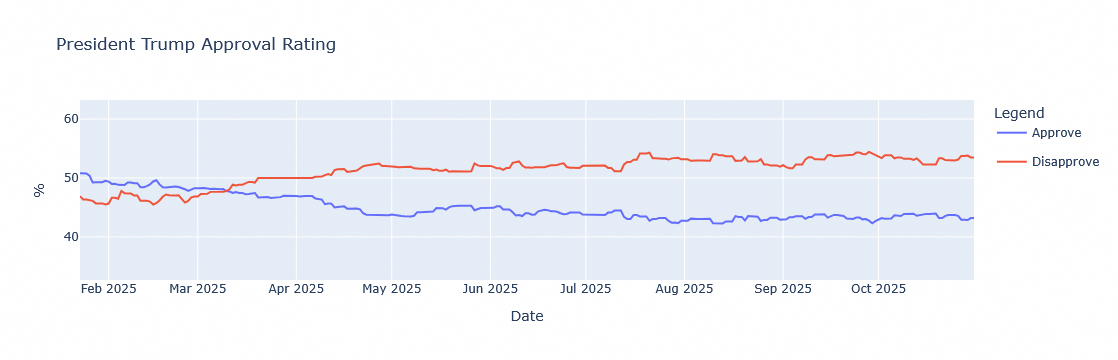

In [271]:
line = px.line(approval_avg, x='Date', y=['Approve', 'Disapprove'])
# scatter = px.scatter(polls_df[polls_df['end_date'] >= pd.to_datetime('2025-01-24')], x='end_date', y=['approve', 'disapprove'])
line.update_traces(hovertemplate=None)
line.update_layout(hovermode='x unified')
# scatter.update_traces(hovertemplate=None, hoverinfo='skip')
fig_approve_CI = go.Figure([
    go.Scatter(
        name='Approve CI Upper Bound',
        x = approval_avg['Date'],
        y = approval_avg['Approve'] + 1.96*approval_std['Approve'],
        mode='lines',
        marker=dict(color='#8be8f2'),
        line=dict(width=0),
        showlegend=False,
        hoverinfo='skip'
    ),
    go.Scatter(
        name='Approve CI Lower Bound',
        x = approval_avg['Date'],
        y = approval_avg['Approve'] - 1.96*approval_std['Approve'],
        mode='lines',
        marker=dict(color='#8be8f2'),
        line=dict(width=0),
        showlegend=False,
        hoverinfo='skip'
    ),  
])
fig_disapprove_CI = go.Figure([
    go.Scatter(
        name='Disapprove CI Upper Bound',
        x = approval_avg['Date'],
        y = approval_avg['Disapprove'] + 1.96*approval_std['Disapprove'],
        mode='lines',
        marker=dict(color='#a3cbec'),
        line=dict(width=0),
        showlegend=False,
        hoverinfo='skip'
    ),
    go.Scatter(
        name='Disapprove CI Lower Bound',
        x = approval_avg['Date'],
        y = approval_avg['Disapprove'] - 1.96*approval_std['Disapprove'],
        mode='lines',
        marker=dict(color='#a3cbec'),
        line=dict(width=0),
        showlegend=False,
        hoverinfo='skip'
    ),  
])

fig = go.Figure(data=line.data + fig_approve_CI.data + fig_disapprove_CI.data)
fig.update_layout(
    title='President Trump Approval Rating',
    xaxis_title='Date',
    yaxis_title='%',
    legend_title='Legend',
    hovermode='x unified'
)
fig.show()

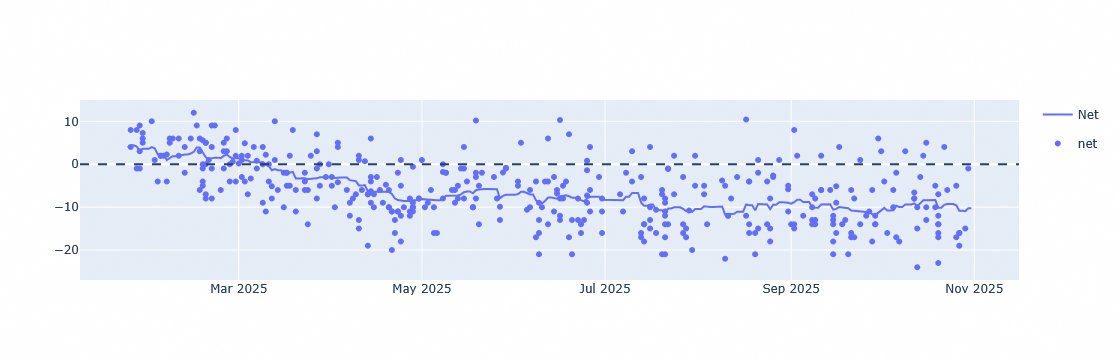

In [272]:
line = px.line(approval_avg, x='Date', y=['Net'])
scatter = px.scatter(polls_df[polls_df['end_date'] >= pd.to_datetime('2025-01-24')], x='end_date', y=['net'])
                     #trendline='lowess', trendline_options=dict(frac=0.2))
fig = go.Figure(data=line.data + scatter.data)
fig.add_hline(y=0, line_dash='dash')
fig.show()

In [273]:
# scatter = px.scatter(polls_df[polls_df['end_date'] >= pd.to_datetime('2025-01-24')], x='end_date', y=['net', 'net_adj'])
# fig = go.Figure(data=scatter.data)
# fig.add_hline(y=0, line_dash='dash')
# fig.show()

In [274]:
def net_col(df: pd.DataFrame, min_date: datetime.date):
#     df_copy = df.set_index(['Date'])
#     return df_copy['approve_mean'] - df_copy['disapprove_mean']
    date_range = pd.date_range(start=min_date, end=datetime.datetime.today(), freq='d', inclusive='both')
    data = df.copy()
    data['net_adj'] = data['approve_adj'] - data['disapprove_adj']
    net_averages = []
    net_stdevs = []
    issue_cols = {'Date': date_range, 'net':[], 'net_std':[]}
    for date in date_range:
    #         try:
            pipelined_df = avgs_pipeline(data, date)
    #         except TypeError:
    #             print('TypeError')
    #             print(date)
            net_avg = np.sum(pipelined_df['net_adj'] * pipelined_df['total_weights'])
            net_std = np.sqrt(np.sum(pipelined_df['total_weights'] * (pipelined_df['net_adj'] - net_avg)**2))

            net_averages.append(net_avg)
            net_stdevs.append(net_std)

    issue_cols['net'].extend(net_averages)
    issue_cols[f'net_std'].extend(net_stdevs)
        
    net_averages, net_stdevs = [], []
        
    return pd.DataFrame(issue_cols)

In [275]:
net_approval = net_col(approval, datetime.date(2025, 1, 23))
net_approval

,Date,net,net_std
0,2025-01-23,3.887254,8.073016
1,2025-01-24,4.419565,7.266629
2,2025-01-25,4.419565,7.266629
3,2025-01-26,4.137905,7.039344
4,2025-01-27,3.107865,6.321786
...,...,...,...
277,2025-10-27,-10.822163,6.949886
278,2025-10-28,-10.822163,6.949886
279,2025-10-29,-10.926292,6.893565
280,2025-10-30,-10.273065,7.112016


In [276]:
net_approval['net_upper_CI'] = net_approval['net'] + 1.96*net_approval['net_std']
net_approval['net_lower_CI'] = net_approval['net'] - 1.96*net_approval['net_std']
net_approval

,Date,net,net_std,net_upper_CI,net_lower_CI
0,2025-01-23,3.887254,8.073016,19.710364,-11.935857
1,2025-01-24,4.419565,7.266629,18.662157,-9.823027
2,2025-01-25,4.419565,7.266629,18.662157,-9.823027
3,2025-01-26,4.137905,7.039344,17.935019,-9.659210
4,2025-01-27,3.107865,6.321786,15.498566,-9.282837
...,...,...,...,...,...
277,2025-10-27,-10.822163,6.949886,2.799614,-24.443939
278,2025-10-28,-10.822163,6.949886,2.799614,-24.443939
279,2025-10-29,-10.926292,6.893565,2.585096,-24.437680
280,2025-10-30,-10.273065,7.112016,3.666487,-24.212618


In [277]:
net_approval.to_csv('net_approval.csv')

### Auxiliary Graph: Individual Pollsters

In [279]:
approval_polls.columns.values

array(['pollster', 'sponsors', 'startdate', 'end_date', 'sample_size',
       'population', 'approve', 'disapprove', 'approve_adj',
       'disapprove_adj', 'net', 'url', 'pred_plus_minus', 'poll_id',
       'pollster_id'], dtype=object)

In [280]:
appr = full_approval.copy()
appr['net_adj'] = appr['approve'] - appr['disapprove']
appr = appr[~appr['pred_plus_minus'].isna()]
pollsters = appr['pollster'].value_counts().index.values
pollsters

array(['Rasmussen Reports', 'YouGov', 'Morning Consult', 'RMG Research',
       'Ipsos', 'Global Strategy Group/GBAO (Navigator Research)',
       'J.L. Partners', 'TIPP Insights', 'Echelon Insights',
       'Harris Insights & Analytics', 'Gallup', 'Quinnipiac University',
       'Emerson College', 'American Research Group',
       'John Zogby Strategies', 'Clarity Campaign Labs', 'AtlasIntel',
       'McLaughlin & Associates', 'Pew Research Center',
       'Beacon Research/Shaw & Co. Research',
       'Marquette University Law School', 'InsiderAdvantage', 'SSRS',
       'Marist College', 'SurveyMonkey',
       'Hart Research Associates/Public Opinion Strategies', 'Civiqs',
       'co/efficient', 'Wick',
       'Fabrizio Lee & Associates/Impact Research', 'Cygnal', 'Leger',
       'High Point University', 'University of Massachusetts (Amherst)',
       'GBAO', 'Public Religion Research Institute',
       'OH Predictive Insights', 'Trafalgar Group',
       'Targoz Market Research', 'The

In [281]:
def approval_today(data: pd.DataFrame):
    # date_range = pd.date_range(start=datetime.date(2025, 1, 23), end=datetime.datetime.today(), freq='d', inclusive='both')
#     yes_averages = []
#     no_averages = []
#     yes_stdevs = []
#     no_stdevs = []
    pipelined_df = avgs_pipeline(data, datetime.datetime.today())
    yes_avg = np.sum(pipelined_df['approve'] * pipelined_df['total_weights'])
    no_avg = np.sum(pipelined_df['disapprove'] * pipelined_df['total_weights'])
    yes_std = np.sqrt(np.sum(pipelined_df['total_weights'] * (pipelined_df['approve'] - yes_avg)**2))
    no_std = np.sqrt(np.sum(pipelined_df['total_weights'] * (pipelined_df['disapprove'] - no_avg)**2))
    net_avg = np.sum(pipelined_df['net'] * pipelined_df['total_weights'])
    net_std = np.sqrt(np.sum(pipelined_df['total_weights'] * (pipelined_df['net'] - net_avg)**2))
    
    #return pd.DataFrame({'Date':date_range, 'Approve':yes_averages, 'Disapprove':no_averages}), pd.DataFrame({'Date':date_range, 'Approve':yes_stdevs, 'Disapprove':no_stdevs}), avgs_pipeline(data, datetime.datetime.today())
    return yes_avg, no_avg, yes_std, no_std, net_avg, net_std

In [282]:
def indiv_pollster_avg(pollster: str):
    df = appr[appr['pollster'] == pollster]
    yes_avg, no_avg, yes_std, no_std, net_avg, net_std = approval_today(df)
    return yes_avg, no_avg, yes_std, no_std, net_avg, net_std

In [283]:
def get_ppm(pollster: str):
    df = ratings[ratings['Pollster'] == pollster]
    ppm = df['Predictive Plus-Minus'].values[0]
    
    return ppm

In [284]:
appr.shape

(601, 27)

In [285]:
def get_num_polls(pollster: str):
    df = appr[appr['pollster'] == pollster]
    num_polls = df.shape[0]
    return num_polls

In [286]:
get_ppm('YouGov')

0.047635015

In [287]:
indiv_pollster_avg('YouGov')

(40.18572182786577,
 56.66996351983664,
 1.1410196059384126,
 1.152822155630108,
 -16.484241691970873,
 1.4374412151688494)

In [288]:
indiv_pollster_avg('RMG Research')

(49.664010000402115,
 48.12549924661445,
 1.6523471228387239,
 0.9327866173345082,
 1.5385107537876375,
 2.547605154399282)

In [289]:
nets = []
net_stdevs = []
ppms = []
nums = []

for p in pollsters:
    _, _, _, _, net, net_std = indiv_pollster_avg(p)
    ppm = get_ppm(p)
    num_polls = get_num_polls(p)
    
    nets.append(net)
    net_stdevs.append(net_std)
    ppms.append(ppm)
    nums.append(num_polls)

In [290]:
# nets

In [291]:
indiv_avgs = pd.DataFrame({'Pollster': pollsters, 'Net Approval': nets, 'Net Stdev': net_stdevs, 'Predictive Plus-Minus': ppms, 'Number of Approval Polls Conducted': nums})
indiv_avgs = indiv_avgs.sort_values(['Net Approval'], ascending=True)
indiv_avgs

,Pollster,Net Approval,Net Stdev,Predictive Plus-Minus,Number of Approval Polls Conducted
13,American Research Group,-22.857799,0.514215,0.818141,9
33,University of Massachusetts (Amherst),-19.998302,0.148581,0.536200,2
18,Pew Research Center,-18.064622,0.504813,0.132230,5
1,YouGov,-16.484242,1.437441,0.047635,72
22,SSRS,-16.003280,0.114123,0.966835,5
4,Ipsos,-15.706270,1.654188,0.442898,27
11,Quinnipiac University,-14.166086,0.600263,-0.290484,10
35,Public Religion Research Institute,-13.999994,0.004078,0.103864,2
20,Marquette University Law School,-13.987017,0.228121,-0.920261,5
5,Global Strategy Group/GBAO (Navigator Research),-13.481168,2.547909,0.804988,15


In [292]:
indiv_avgs.to_csv('indiv_pollster_avgs.csv')

In [293]:
reg = lm.LinearRegression()
reg.fit(indiv_avgs[['Predictive Plus-Minus']], indiv_avgs['Net Approval'])
reg.coef_, reg.intercept_

(array([-3.09433768]), -6.541694770706445)

In [294]:
r = r_regression(indiv_avgs[['Predictive Plus-Minus']], indiv_avgs['Net Approval'])
r

array([-0.24112816])

In [295]:
net_approval['net'].diff()

0               NaN
1      5.323114e-01
2     -8.881784e-16
3     -2.816602e-01
4     -1.030040e+00
           ...     
277   -1.277222e+00
278    0.000000e+00
279   -1.041292e-01
280    6.532264e-01
281    1.776357e-15
Name: net, Length: 282, dtype: float64

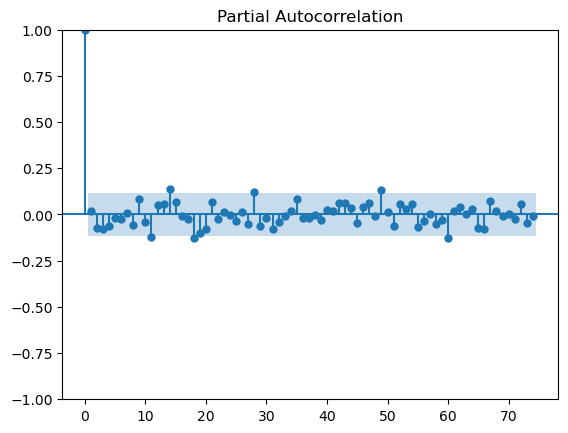

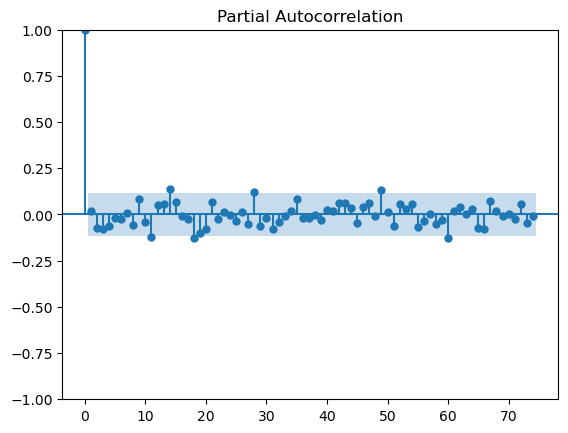

In [296]:
plot_pacf(net_approval['net'].diff()[1:], lags=np.arange(75))

In [297]:
armod_sm = AutoReg(net_approval['net'].diff()[1:].values, lags = 1, trend = 'c').fit()
# print(armod_sm.summary())

In [298]:
armod_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:                      y   No. Observations:                  281
Model:                     AutoReg(1)   Log Likelihood                -209.539
Method:               Conditional MLE   S.D. of innovations              0.511
Date:                Fri, 31 Oct 2025   AIC                            425.077
Time:                        12:04:39   BIC                            435.981
Sample:                             1   HQIC                           429.451
                                  281                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0517      0.031     -1.682      0.093      -0.112       0.009
y.L1           0.0163      0.060      0.273      0.785      -0.101       0.133
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           61.5124           +0.0000j           61.5124            0.0000
-----------------------------------------------------------------------------
"""

In [299]:
k, n_train = 15, 208
fcast = armod_sm.get_prediction(start = n_train, end = n_train + k - 1)
fcast_mean = fcast.predicted_mean
fcast_mean

array([-0.05165153, -0.07075038, -0.02781353, -0.05165153, -0.05165153,
       -0.05356902, -0.06919863, -0.03451653, -0.05165153, -0.04271121,
       -0.05165153, -0.05165153, -0.0533347 , -0.05488296, -0.04634551])